In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from scipy import stats
from datetime import timedelta

Potential questions: 
- What products are likely to be bought together? --> Recommendation system
- What are the future revenues of customers based on their customer cluster?--> Automation of Sales activities
- what is the likely demand for this product today based on past purchases of the product? --> Working capital optimization

The required data can be downloaded from http://archive.ics.uci.edu/ml/datasets/Online+Retail+II as an xlsx file.

In [2]:
df = pd.read_excel("online_retail_II.xlsx")
df.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [ ]:
df.info()
df.describe()

In [3]:
df['total_amount'] = df.Price * df.Quantity
df['invoice_date'] = pd.DatetimeIndex(df['InvoiceDate']).date
df['invoice_time'] = pd.DatetimeIndex(df['InvoiceDate']).time
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_amount,invoice_date,invoice_time
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01,07:45:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,07:45:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,07:45:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01,07:45:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01,07:45:00


In [4]:
#Filtering all values which have no Country, 
df.dropna()
df.drop(df[df.total_amount <= 0].index, inplace=True)
df.drop(df[df.Quantity <= 0].index, inplace=True)

In [ ]:
df.head(20)

In [5]:
dataset_cutoff_date = df['InvoiceDate'].max() + timedelta(days=1)

In [6]:
# Grouping by CustomerID
## and Calculation frequency 
rfm = df.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda x: (dataset_cutoff_date - x.max()).days,
        'Invoice': 'count',
        'total_amount': 'sum'})

In [7]:
rfm.describe()

,InvoiceDate,Invoice,total_amount
count,4312.000000,4312.000000,4312.000000
mean,91.171846,94.541744,2048.238236
std,96.860633,202.046410,8914.481280
min,1.000000,1.000000,2.950000
25%,18.000000,18.000000,307.987500
50%,53.000000,44.000000,706.020000
75%,136.000000,102.000000,1723.142500
max,374.000000,5570.000000,349164.350000


In [8]:
# Rename the columns 
rfm.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'total_amount': 'Monetary'}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,33,372.86
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,102,2671.14
12351.0,11,21,300.93


In [ ]:
#rfm.Recency.hist(bins=100)
rfm.Frequency.hist(bins=100)
#rfm.Monetary.hist()


In [9]:
rfm = rfm[rfm.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [10]:
rfm.describe()

,Recency,Frequency,Monetary
count,4254.000000,4254.000000,4254.000000
mean,92.185002,80.204278,1483.764871
std,97.011676,101.820688,2397.871538
min,1.000000,1.000000,2.950000
25%,19.000000,18.000000,305.600000
50%,53.000000,43.000000,685.650000
75%,138.000000,99.000000,1656.105000
max,374.000000,695.000000,28019.580000


Text(0, 0.5, 'Inertia')

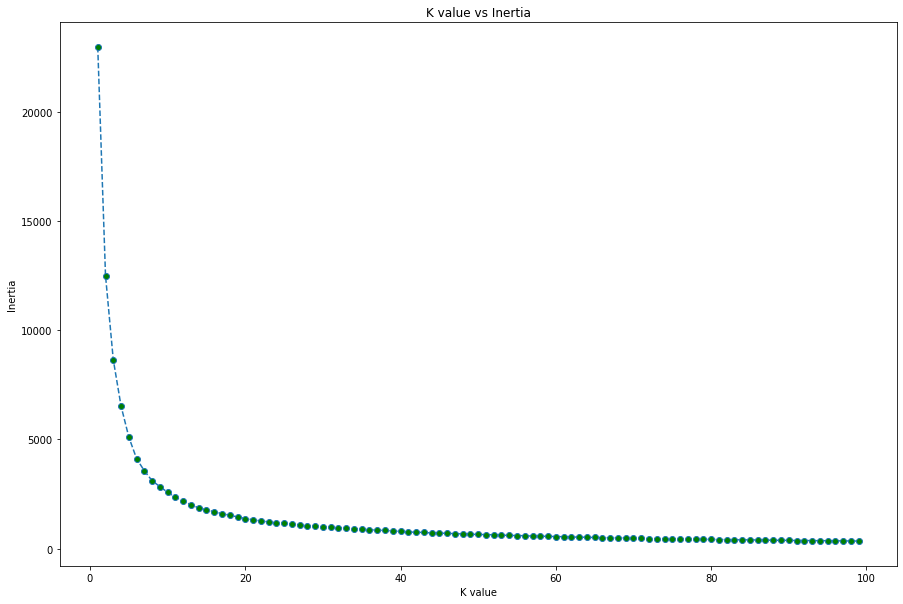

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler,StandardScaler

# Scaling with Robust Scaler
rfm_model = rfm[['Recency','Frequency','Monetary']]
standar = RobustScaler()
standar.fit(rfm_model)
rfm_model = standar.transform(rfm_model)
rfm_model = pd.DataFrame(rfm_model, columns=['Recency','Frequency','Monetary'])
rfm_model['Customer Id'] = rfm.index
X_scaled = rfm_model[['Recency','Frequency','Monetary']]

In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=42).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

Score for number of cluster(s) 2: -12497.98766087585
Silhouette score for number of cluster(s) 2: 0.6653076715291593
Davies Bouldin score for number of cluster(s) 2: 0.8201429417384436
Score for number of cluster(s) 3: -8647.020428017811


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Silhouette score for number of cluster(s) 3: 0.5533170613029338
Davies Bouldin score for number of cluster(s) 3: 0.8125540254366225
Score for number of cluster(s) 4: -6530.435804330717


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Silhouette score for number of cluster(s) 4: 0.4346935027048627
Davies Bouldin score for number of cluster(s) 4: 0.7764163586066256
Score for number of cluster(s) 5: -5110.629423379586


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Silhouette score for number of cluster(s) 5: 0.44811122554579985
Davies Bouldin score for number of cluster(s) 5: 0.85677726674404


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 6: -4124.989248291126
Silhouette score for number of cluster(s) 6: 0.45465458263755315
Davies Bouldin score for number of cluster(s) 6: 0.8104016296458126


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 7: -3564.0384860443983
Silhouette score for number of cluster(s) 7: 0.4224433474101962
Davies Bouldin score for number of cluster(s) 7: 0.8525374010919063


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 8: -3109.8822969060684
Silhouette score for number of cluster(s) 8: 0.42649494808077526
Davies Bouldin score for number of cluster(s) 8: 0.8271274579427947


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 9: -2839.4726079441216
Silhouette score for number of cluster(s) 9: 0.38939102881094717
Davies Bouldin score for number of cluster(s) 9: 0.8810509887568341


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 10: -2603.8394101708236
Silhouette score for number of cluster(s) 10: 0.3883178376526284
Davies Bouldin score for number of cluster(s) 10: 0.8685259242103202


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 11: -2373.2671264378205
Silhouette score for number of cluster(s) 11: 0.36880692497508905
Davies Bouldin score for number of cluster(s) 11: 0.883538546875137


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


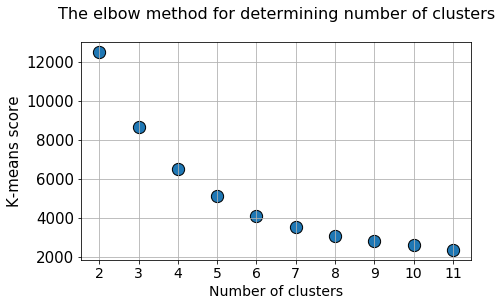

In [51]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

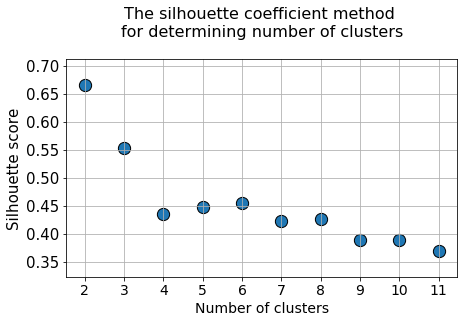

In [21]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

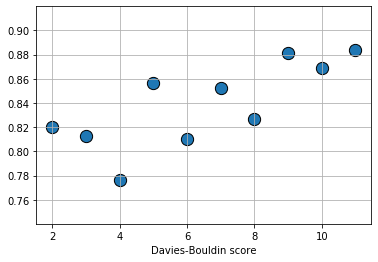

In [22]:
plt.scatter(x=[i for i in range(2,12)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

In [73]:
#adding clusters to the dataset
km = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
X_scaled["cluster"] = km.predict(X_scaled)
rfm["cluster"] = km.predict(X_scaled)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


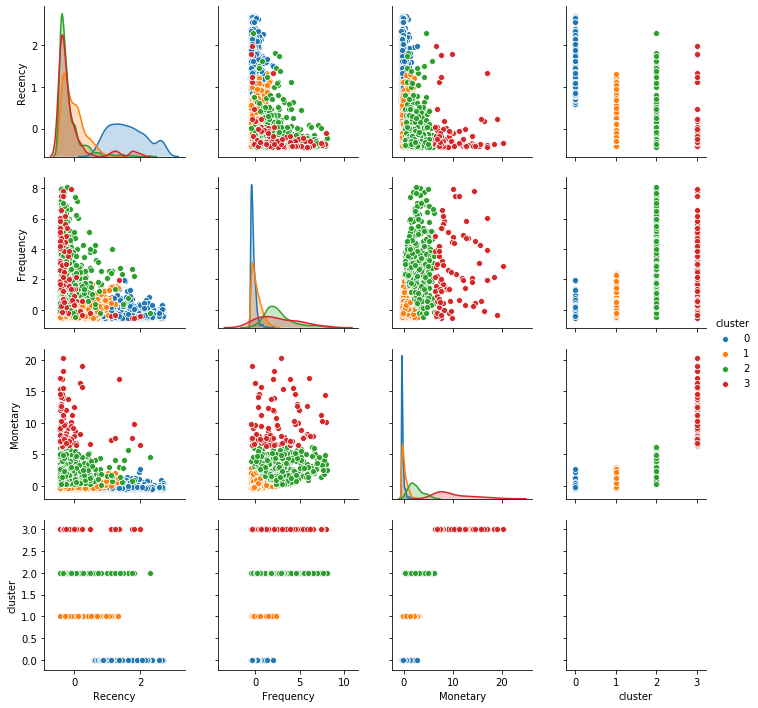

In [71]:
sns.pairplot(X_scaled, kind='scatter', hue='cluster')

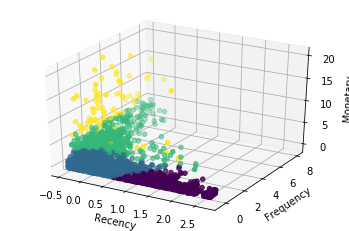

In [59]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_data = X_scaled.Recency
y_data = X_scaled.Frequency
z_data = X_scaled.Monetary
color_data = X_scaled.cluster
ax.scatter(x_data,y_data,z_data, c= color_data)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

In [77]:
rfm.reset_index(level=0, inplace=True)

In [80]:
rfm.groupby("cluster").mean()

,Customer ID,Recency,Frequency,Monetary
cluster,,,,
0,15422.653885,245.588295,24.113017,395.416008
1,15356.811533,48.755031,55.764319,926.221948
2,15232.964824,33.023451,255.351759,3951.518799
3,15029.451220,37.548780,253.085366,14239.808073
